<a href="https://colab.research.google.com/github/behdad13/time-series-forecasting/blob/main/RESNET_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importing necessary libraries 

In [ ]:
#installing necessary libraries
!pip install torch
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.5 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 210 kB 74.2 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 147 kB 80.9 MB/s 
     |████████████████████████████████| 112 kB 72.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=db02451c151d206ad0821eee9b34581501f1b3ac1587e6abffadae513bc8fb18
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.1.0
    Unins

In [ ]:
#import necessary libraries
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy import array
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.trial import TrialState
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [ ]:
#set seed
seed_val = 67
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## importing pre-processed dataset

In [ ]:
#import the dataset
data = pd.read_csv('Data_Toronto.csv', low_memory=False)

#select the most relevent feature from the dataset
data = data[['Year', 'Month', 'Day', 'Hour', 'week_end','temperature', 'humidex', 'Ontario_Real_price', 'Electricity_Load']]

In [ ]:
#define the test and train set
seq = 5*24
horizon = 24
train = data.iloc[17520+8760+8786 - seq : 43824 + horizon]
test = data.iloc[43824 - seq : 43824+30*24 + horizon]

## train-val-test split

In [ ]:
#defining the training proportion
#seperating train and validation set
train_size = int(len(data)*0.80)      
valid_size = int(len(data)*0.20)
df_train, df_val = data[:train_size], data[train_size+1:]
df_train.shape, df_val.shape, test.shape

((38534, 9), (9633, 9), (864, 9))

In [ ]:
# scaling each features of the dataset
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train),index = df_train.index, columns = df_train.columns)
df_val = pd.DataFrame(scaler.transform(df_val),index = df_val.index, columns = df_val.columns)
test = pd.DataFrame(scaler.transform(test),index = test.index, columns = test.columns)

## Make a time sequneces

In [ ]:
df_train = df_train.to_numpy()
df_val = df_val.to_numpy()
test = test.to_numpy()

In [ ]:
# split a multivariate sequence into samples
from numpy import array
def split_sequences(sequences, n_steps, for_hor):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-for_hor:
            break
        # gather input and output parts of the pattern
        # sequence_x ranges from 0 to seq_len and all columns except the last one.
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:end_ix+for_hor, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
n_timesteps = 24*5
for_hor = 24
X_train, y_train = split_sequences(df_train, n_timesteps, for_hor)
X_val, y_val = split_sequences(df_val, n_timesteps, for_hor)
X_test, y_test = split_sequences(test, n_timesteps, for_hor)

In [ ]:
print(X_test.shape, y_test.shape)

(721, 120, 9) (721, 24)


In [ ]:
n_timesteps + len(X_train) + for_hor-1 == len(df_train)

True

 ## Data Loader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64


X_train_t = torch.Tensor(X_train)
y_train_t = torch.Tensor(y_train)
X_val_t = torch.Tensor(X_val)
y_val_t = torch.Tensor(y_val)
X_test_t = torch.Tensor(X_test)
y_test_t = torch.Tensor(y_test)

train = TensorDataset(X_train_t, y_train_t)
val = TensorDataset(X_val_t, y_val_t)
test_w1 = TensorDataset(X_test_t, y_test_t)


train_loader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle = False, drop_last=True)
test_loader_one_w1 = DataLoader(test_w1, batch_size=1, shuffle = False, drop_last=True)

In [ ]:
#check the size of the train set
X_train_t.shape, y_train_t.shape

(torch.Size([38391, 120, 9]), torch.Size([38391, 24]))

In [ ]:
#just for testing the size of the batch
next(iter(train_loader))[1].size(), next(iter(train_loader))[0].size()

(torch.Size([64, 24]), torch.Size([64, 120, 9]))

## deep learning model

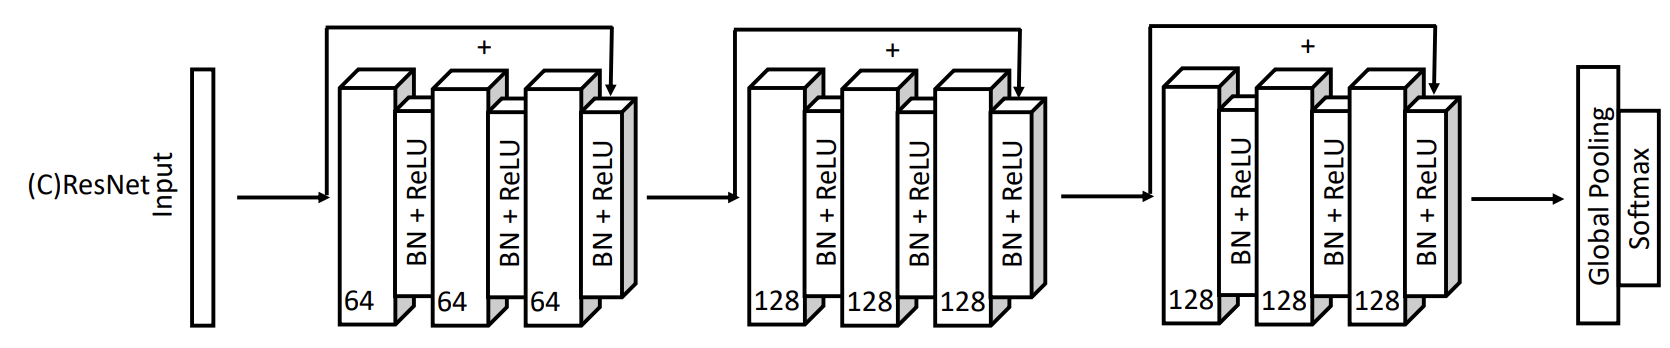

The follwoing code includes Batch Normalaization in each block and Global pooling layer at the end the structure. However, I inactivated these sections a and run the model (those sections worsen the result)

In [ ]:
#here is the code for a ConvBlock
#batch-normalization and GAP (global average plooing) are removerd from the code becasue it worsens the results.

#making a global average plooing layer
class GlobalAveragePooling1D(nn.Module):
    def __init__(self, data_format='channels_last'):
        super(GlobalAveragePooling1D, self).__init__()

        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.mean(input, axis=self.step_axis)



#make a convolution block
class ConvBlock(nn.Module):
    def __init__(self, ni, nf, ks, drop=0.):
        super(ConvBlock, self).__init__()

        self.conv1d = nn.Conv1d(ni,nf,ks)
        self.dropout = nn.Dropout(drop)
        self.batch_norm = nn.BatchNorm1d(nf)
        self.relu = nn.ReLU()
        self.cpad1d = nn.ConstantPad1d(((ks-1), 0), 0)  

    def forward(self, x):
        x = self.cpad1d(self.conv1d(x))
        x = self.dropout(x)
        #x = self.batch_norm(x)  #batch normalization
        x = self.relu(x)
        return x



#make a residual block
class ResBlock(nn.Module):
    def __init__(self, ni, nf, kss=[7, 5, 3], drop=0.):
        super(ResBlock, self).__init__()

        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2])
        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1)
        #self.add = torch.add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        #print(res.shape)
        x1 = self.convblock1(x)
        #print(x1.shape)
        x2 = self.convblock2(x1)
        #print(x2.shape)
        x = self.convblock3(x2)
        #print(x.shape)
        x = torch.add(x, self.shortcut(res))
        #print(x.shape)
        out = self.act(x)
        #print(out.shape)
        return out



#make a residual network
class ResNet(nn.Module):
    def __init__(self, c_in, c_out, seq_len=120):
        super(ResNet, self).__init__()
        nfs=[64, 128, 128]
        self.resblock1 = ResBlock(c_in, nfs[0], kss=[7, 5, 3])
        self.resblock2 = ResBlock(nfs[0], nfs[1], kss=[7, 5, 3])
        self.resblock3 = ResBlock(nfs[1], nfs[2], kss=[7, 5, 3])
        self.fc = nn.Linear(nfs[2]*seq_len, c_out)       #remove 'seq_len' term when you activate the global pooling
        self.GAP1D = GlobalAveragePooling1D()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.resblock1(x)
        #print(x.shape)
        x = self.resblock2(x)
        #print(x.shape)
        x = self.resblock3(x)
        #print(x.shape)
        #out = self.GAP1D(x)          #activate the line when you consider the global pooling layer in your model
        x = torch.flatten(x, start_dim=1)
        return self.fc(x)

In [ ]:
x=torch.rand(64, 120, 9)
model = ResNet(c_in=9, c_out=24, seq_len=120)
y=model(x)
y.shape

torch.Size([64, 24])

In [ ]:
#defining an objective function of the bayesian Optimization and which parameters need to be tuned
epochs = 250 
patience = 20
loss = nn.MSELoss()
min_val_loss_total=np.inf

def objective(trial):
    #define the infinity variable
    min_val_loss = np.inf

    # Generate the model.
    model = ResNet(c_in=9, c_out=24, seq_len=120).cuda()            #hidden_size2 = trial.suggest_int("hidden_dim2", 16, 128),    

    # Generate the optimizers.
    loss_fn = nn.MSELoss() 
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # Training of the model
    counter = 0
    for i in range(epochs):
        mse_train = 0
        iteration_start = time.monotonic()
        for batch_x, batch_y in train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            y_pred = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                output = model(batch_x)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        if min_val_loss > mse_val:
            min_val_loss = mse_val
            counter = 0
        else: 
            counter += 1
        if counter == patience:
            break   

        global min_val_loss_total
        if min_val_loss_total > mse_val:
            min_val_loss_total = mse_val
            torch.save(model.state_dict(), "RESNET_BO.pt")

        if i % 20 == 0:
            print("Iter: ", i, "train: ", (mse_train), "val: ", (mse_val))
        
        if trial.should_prune():
            raise optuna.TrialPruned()
            
        trial.report(min_val_loss, i)
        
    return min_val_loss

In [ ]:
if __name__ == "__main__":
    #create the study
    study = optuna.create_study(direction="minimize", 
                                sampler=optuna.samplers.TPESampler(), 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    #calling the optimzation process
    study.optimize(objective, n_trials=40)  

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-27 03:11:19,569] A new study created in memory with name: no-name-588812c4-67dc-475d-aef2-32952dfe7061


Iter:  0 train:  597.3769291639328 val:  236.57562685012817
Iter:  20 train:  72.13601709902287 val:  96.64062938094139
Iter:  40 train:  45.4731151163578 val:  93.22253737598658
Iter:  60 train:  30.65480807982385 val:  96.1790572553873
Iter:  80 train:  22.565759928897023 val:  87.67875237762928
Iter:  100 train:  19.61674408428371 val:  80.13942825049162


[I 2022-12-27 03:27:46,400] Trial 0 finished with value: 76.6008762717247 and parameters: {'lr': 3.021839357463297e-05}. Best is trial 0 with value: 76.6008762717247.


Iter:  0 train:  484.517719656229 val:  192.11141473054886
Iter:  20 train:  55.437937658280134 val:  74.96401254832745
Iter:  40 train:  18.661169841885567 val:  71.34844886511564


[I 2022-12-27 03:34:18,427] Trial 1 finished with value: 70.09306026995182 and parameters: {'lr': 0.00018088127785144823}. Best is trial 1 with value: 70.09306026995182.


Iter:  0 train:  615.1560771167278 val:  293.2525958418846
Iter:  20 train:  61.11598793417215 val:  125.79875293374062
Iter:  40 train:  37.90562178194523 val:  136.02296917140484


[I 2022-12-27 03:42:43,755] Trial 2 finished with value: 111.7769164443016 and parameters: {'lr': 2.494099588614145e-05}. Best is trial 1 with value: 70.09306026995182.


Iter:  0 train:  458.41404984891415 val:  168.46790796518326
Iter:  20 train:  59.90478942915797 val:  104.0960800871253


[I 2022-12-27 03:48:18,085] Trial 3 finished with value: 82.32588493078947 and parameters: {'lr': 7.840382599255116e-05}. Best is trial 1 with value: 70.09306026995182.


Iter:  0 train:  1676.0713393241167 val:  170.12419566512108
Iter:  20 train:  50.034370090812445 val:  156.08077827095985


[I 2022-12-27 03:52:02,233] Trial 4 finished with value: 100.72805118560791 and parameters: {'lr': 0.0006351822332697037}. Best is trial 1 with value: 70.09306026995182.


Iter:  0 train:  429.7004106938839 val:  199.02736115455627


[I 2022-12-27 03:53:00,888] Trial 5 pruned. 


Iter:  0 train:  824.2833729684353 val:  335.7680176496506


[I 2022-12-27 03:53:59,916] Trial 6 pruned. 


Iter:  0 train:  796.1140086650848 val:  292.62677359580994


[I 2022-12-27 03:54:58,955] Trial 7 pruned. 


Iter:  0 train:  516.4094951152802 val:  212.94544523954391


[I 2022-12-27 03:55:57,689] Trial 8 pruned. 


Iter:  0 train:  458.7803877592087 val:  145.74578553438187
Iter:  20 train:  50.219684548676014 val:  106.11377707123756
Iter:  40 train:  22.678970612585545 val:  69.98079906404018
Iter:  60 train:  12.521131321787834 val:  69.9721010401845


[I 2022-12-27 04:06:32,436] Trial 9 finished with value: 60.43660243600607 and parameters: {'lr': 0.00013736088296461692}. Best is trial 9 with value: 60.43660243600607.


Iter:  0 train:  630.9459619522095 val:  150.27162438631058
Iter:  20 train:  36.056833662092686 val:  98.14044569432735


[I 2022-12-27 04:11:40,531] Trial 10 finished with value: 66.98003627359867 and parameters: {'lr': 0.00028969382583540846}. Best is trial 9 with value: 60.43660243600607.


Iter:  0 train:  748.7596911787987 val:  139.71107459068298
Iter:  20 train:  43.04191079363227 val:  74.24199752882123
Iter:  40 train:  18.386214526370168 val:  64.20616781525314
Iter:  60 train:  10.119903517886996 val:  50.986793756484985
Iter:  80 train:  7.568831446580589 val:  47.88022317737341
Iter:  100 train:  6.398682880215347 val:  45.08915238082409


[I 2022-12-27 04:26:12,548] Trial 11 finished with value: 45.00471671298146 and parameters: {'lr': 0.00033094835319638524}. Best is trial 11 with value: 45.00471671298146.


Iter:  0 train:  4476.277475610375 val:  165.4116489291191


[I 2022-12-27 04:28:58,467] Trial 12 pruned. 


Iter:  0 train:  821.0974679738283 val:  127.39186903834343
Iter:  20 train:  38.63872543722391 val:  87.53775795176625
Iter:  40 train:  14.828303436748683 val:  81.2500657401979


[I 2022-12-27 04:37:25,616] Trial 13 pruned. 


Iter:  60 train:  11.886650033295155 val:  68.26053011417389
Iter:  0 train:  537.9047354012728 val:  150.20892840623856
Iter:  20 train:  44.10575179383159 val:  93.17068687826395


[I 2022-12-27 04:41:18,831] Trial 14 pruned. 


Iter:  0 train:  466.94611218571663 val:  175.35739988088608


[I 2022-12-27 04:42:17,520] Trial 15 pruned. 


Iter:  0 train:  1044.1173806637526 val:  164.16651612520218


[I 2022-12-27 04:43:32,468] Trial 16 pruned. 


Iter:  0 train:  531.0249827206135 val:  213.8331783413887


[I 2022-12-27 04:44:31,475] Trial 17 pruned. 


Iter:  0 train:  492.04180635511875 val:  166.48816427588463


[I 2022-12-27 04:45:30,124] Trial 18 pruned. 


Iter:  0 train:  2836.326755389571 val:  167.41143095493317
Iter:  20 train:  50.31859450787306 val:  59.83751672692597
Iter:  40 train:  23.336238427087665 val:  57.6005233079195


[I 2022-12-27 04:51:26,048] Trial 19 finished with value: 56.70375854894519 and parameters: {'lr': 0.0008326308607628666}. Best is trial 11 with value: 45.00471671298146.


Iter:  0 train:  3670.2147436589003 val:  120.81550894677639
Iter:  20 train:  40.80027097836137 val:  72.07776519656181
Iter:  40 train:  20.283157125115395 val:  53.45415617711842
Iter:  60 train:  13.606723649427295 val:  48.97053383663297
Iter:  80 train:  10.116582068614662 val:  46.86132975667715
Iter:  100 train:  8.330064345151186 val:  44.736928596161306


[I 2022-12-27 05:07:50,089] Trial 20 finished with value: 41.31717788986862 and parameters: {'lr': 0.0009969511853379083}. Best is trial 20 with value: 41.31717788986862.


Iter:  0 train:  1581.8643004149199 val:  157.56914868950844


[I 2022-12-27 05:08:48,482] Trial 21 pruned. 


Iter:  0 train:  3613.675990089774 val:  163.4700374007225


[I 2022-12-27 05:09:46,613] Trial 22 pruned. 


Iter:  0 train:  1833.874153420329 val:  151.47240775823593


[I 2022-12-27 05:11:59,831] Trial 23 pruned. 


Iter:  0 train:  1153.80685980618 val:  196.23348262906075


[I 2022-12-27 05:14:29,708] Trial 24 pruned. 


Iter:  0 train:  2575.234679490328 val:  119.65741507709026
Iter:  20 train:  49.58443710580468 val:  76.07837535440922


[I 2022-12-27 05:18:14,133] Trial 25 pruned. 


Iter:  0 train:  819.6737333983183 val:  163.269727319479


[I 2022-12-27 05:19:12,284] Trial 26 pruned. 


Iter:  0 train:  1944.0047086179256 val:  137.28860753774643


[I 2022-12-27 05:20:10,826] Trial 27 pruned. 


Iter:  0 train:  1277.7695239037275 val:  130.77360716462135
Iter:  20 train:  40.42000546306372 val:  60.13734693452716
Iter:  40 train:  19.445995185524225 val:  65.27770633995533
Iter:  60 train:  12.640999642200768 val:  46.455026905983686
Iter:  80 train:  9.897647644393146 val:  47.68170437216759


[I 2022-12-27 05:31:39,092] Trial 28 finished with value: 44.36809425055981 and parameters: {'lr': 0.0004990738149288712}. Best is trial 20 with value: 41.31717788986862.


Iter:  0 train:  1221.6286675184965 val:  148.85261955857277


[I 2022-12-27 05:34:25,696] Trial 29 pruned. 


Iter:  0 train:  521.0997509211302 val:  153.33965981006622
Iter:  20 train:  42.50478041917086 val:  70.2843687236309
Iter:  40 train:  19.36564577743411 val:  72.96032456681132


[I 2022-12-27 05:40:24,237] Trial 30 pruned. 


Iter:  0 train:  2516.096744194627 val:  164.7526381611824


[I 2022-12-27 05:42:12,390] Trial 31 pruned. 


Iter:  0 train:  1276.6307232677937 val:  151.0236029624939


[I 2022-12-27 05:44:17,418] Trial 32 pruned. 


Iter:  0 train:  733.0495959818363 val:  126.65797156095505
Iter:  20 train:  50.51349623501301 val:  70.48311733454466
Iter:  40 train:  17.592718560248613 val:  59.719000820070505


[I 2022-12-27 05:52:44,638] Trial 33 pruned. 


Iter:  60 train:  9.643782316707075 val:  55.692418694496155
Iter:  0 train:  2276.2185510247946 val:  154.69502040743828


[I 2022-12-27 05:54:49,504] Trial 34 pruned. 


Iter:  0 train:  1206.97212138772 val:  165.29366835951805


[I 2022-12-27 05:56:54,142] Trial 35 pruned. 


Iter:  0 train:  538.2662115097046 val:  209.18549650907516


[I 2022-12-27 05:57:52,635] Trial 36 pruned. 


Iter:  0 train:  1017.5299869775772 val:  341.19974970817566


[I 2022-12-27 05:58:51,753] Trial 37 pruned. 


Iter:  0 train:  493.67232544720173 val:  199.82104828953743


[I 2022-12-27 05:59:50,387] Trial 38 pruned. 


Iter:  0 train:  2836.0021817833185 val:  131.02815653383732


[I 2022-12-27 06:00:48,818] Trial 39 pruned. 


Study statistics: 
  Number of finished trials:  40
  Number of pruned trials:  29
  Number of complete trials:  11
Best trial:
  Value:  41.31717788986862
  Params: 
    lr: 0.0009969511853379083


<ipython-input-21-daaa700951ce>:2: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



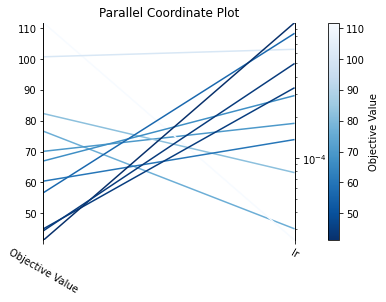

In [ ]:
#Visualizing sets of tunned yperparameters based on the BO
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=[ "lr" ])
optuna.visualization.plot_param_importances(study)

In [ ]:
#Download the PT file
from google.colab import files
files.download('RESNET_BO.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Read the pk file
model = ResNet(c_in=9, c_out=24, seq_len=120)

model.load_state_dict(torch.load("RESNET_BO.pt"))

<All keys matched successfully>

In [ ]:
#call a desacaler function for the further analysis
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [ ]:
# the error calculation function
def calculate_metrics(values_descaled, prediction_descaled):
    result_metrics = {
                      'MAE' : mean_absolute_error(values_descaled, prediction_descaled),
                      'MSE' : mean_squared_error(values_descaled, prediction_descaled),
                      'R2'  : r2_score(values_descaled, prediction_descaled),
                      'MAPE': mean_absolute_percentage_error(values_descaled, prediction_descaled)
                      }
    print("Root Mean Squared Error :  ", result_metrics["MSE"]**0.5)
    print("R^2                :       ", result_metrics["R2"])
    print("Mean Absolute Error:       ", result_metrics["MAE"])
    print("MAPE               :       ", result_metrics["MAPE"])
    
    return result_metrics

Test set results

In [ ]:
# feeding the model with the test set.
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y in test_loader_one_w1:
        batch_x = batch_x
        batch_y = batch_y
        output = model(batch_x)
        output = output.squeeze(1)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
preds = np.concatenate(preds)
true = np.concatenate(true)

Illustration of one-step, two-step, three-step, and 24-step ahead forecasting

error for next 1 hour prediction
Root Mean Squared Error :   433.04820373358285
R^2                :        0.5935424730506873
Mean Absolute Error:        383.1360408449636
MAPE               :        0.06796532379033454


error for next 2 hour prediction
Root Mean Squared Error :   435.49487144898757
R^2                :        0.5946498740815553
Mean Absolute Error:        383.06686134708735
MAPE               :        0.06790661617535726


error for next 3 hour prediction
Root Mean Squared Error :   422.37372657387624
R^2                :        0.6268920590005993
Mean Absolute Error:        368.12919204013525
MAPE               :        0.06503585384484337


error for next 24 hour prediction
Root Mean Squared Error :   358.3278344644639
R^2                :        0.7161104157066321
Mean Absolute Error:        297.6009861791349
MAPE               :        0.05056922202118895


1-step ahead forecast
2-step ahead forecast
3-step ahead forecast
24-step ahead forecast


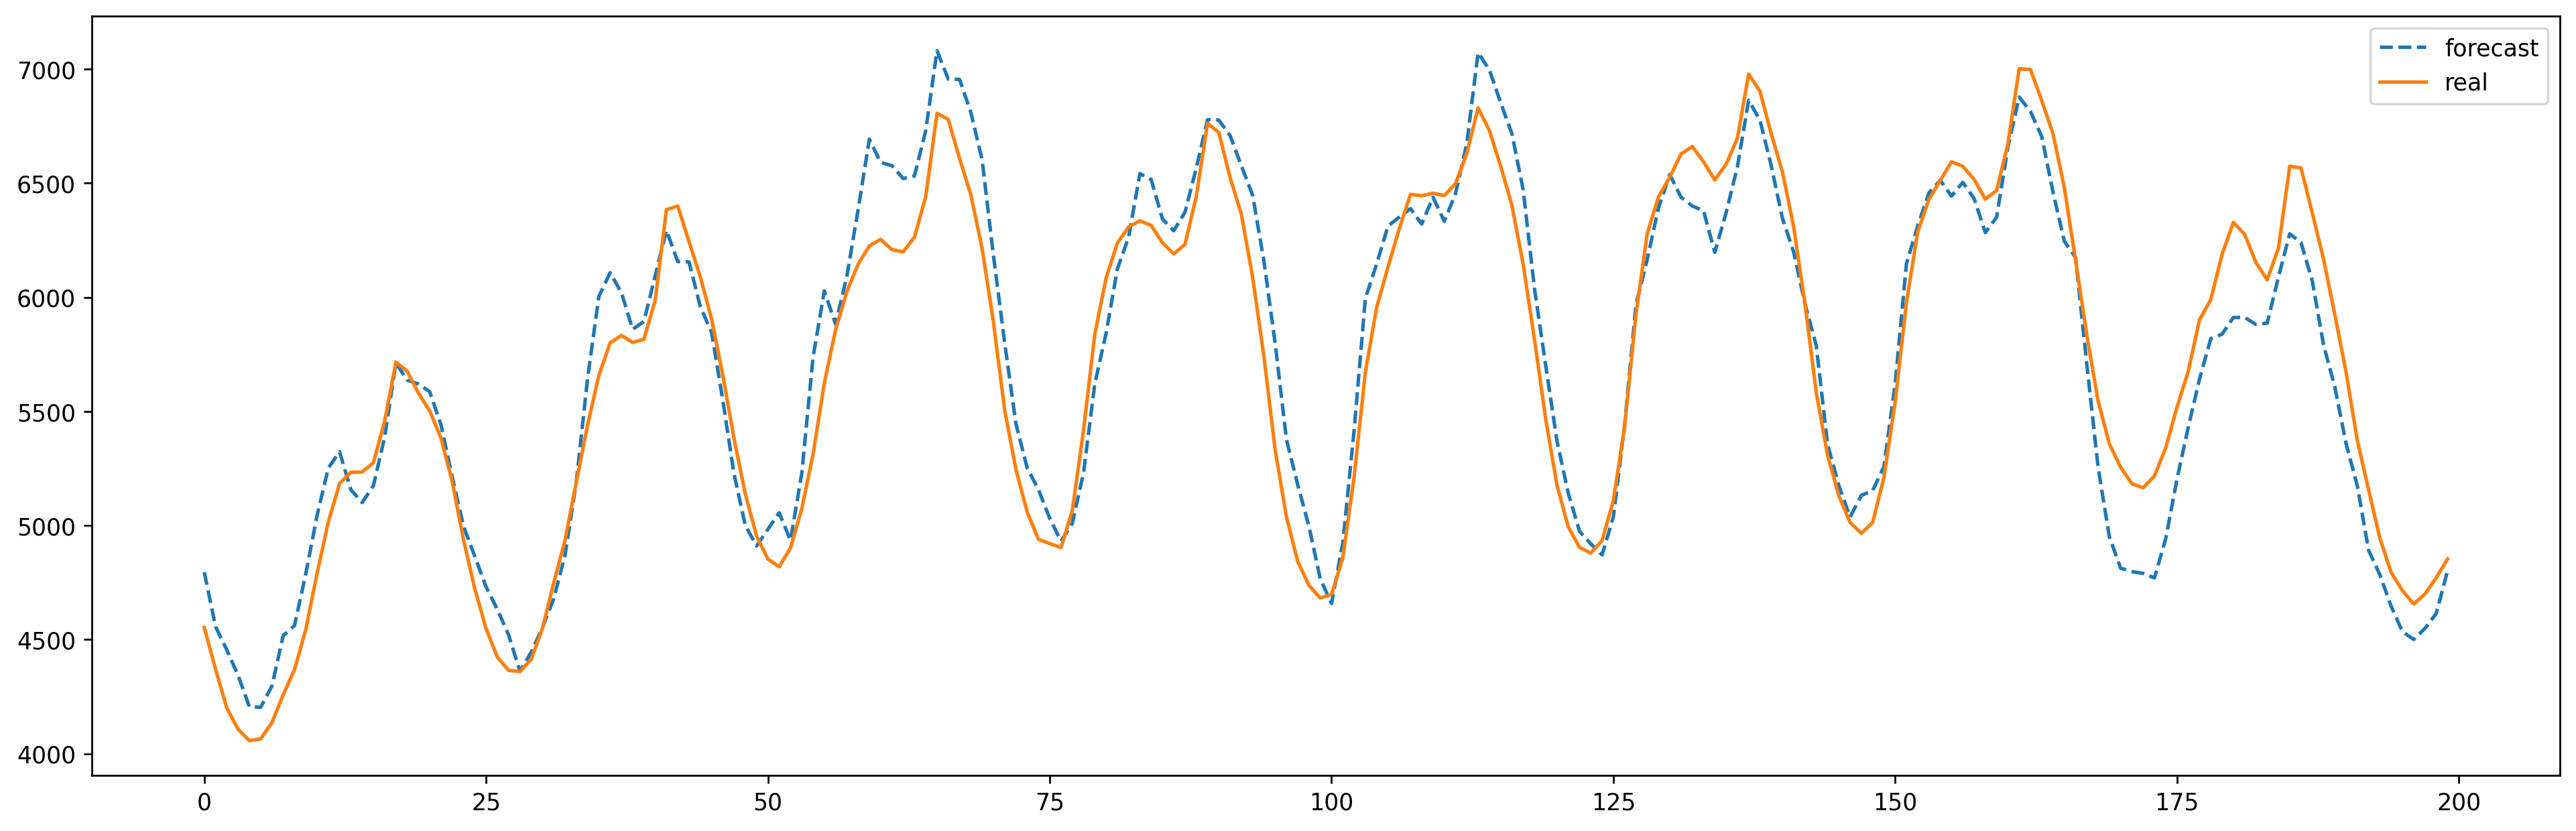

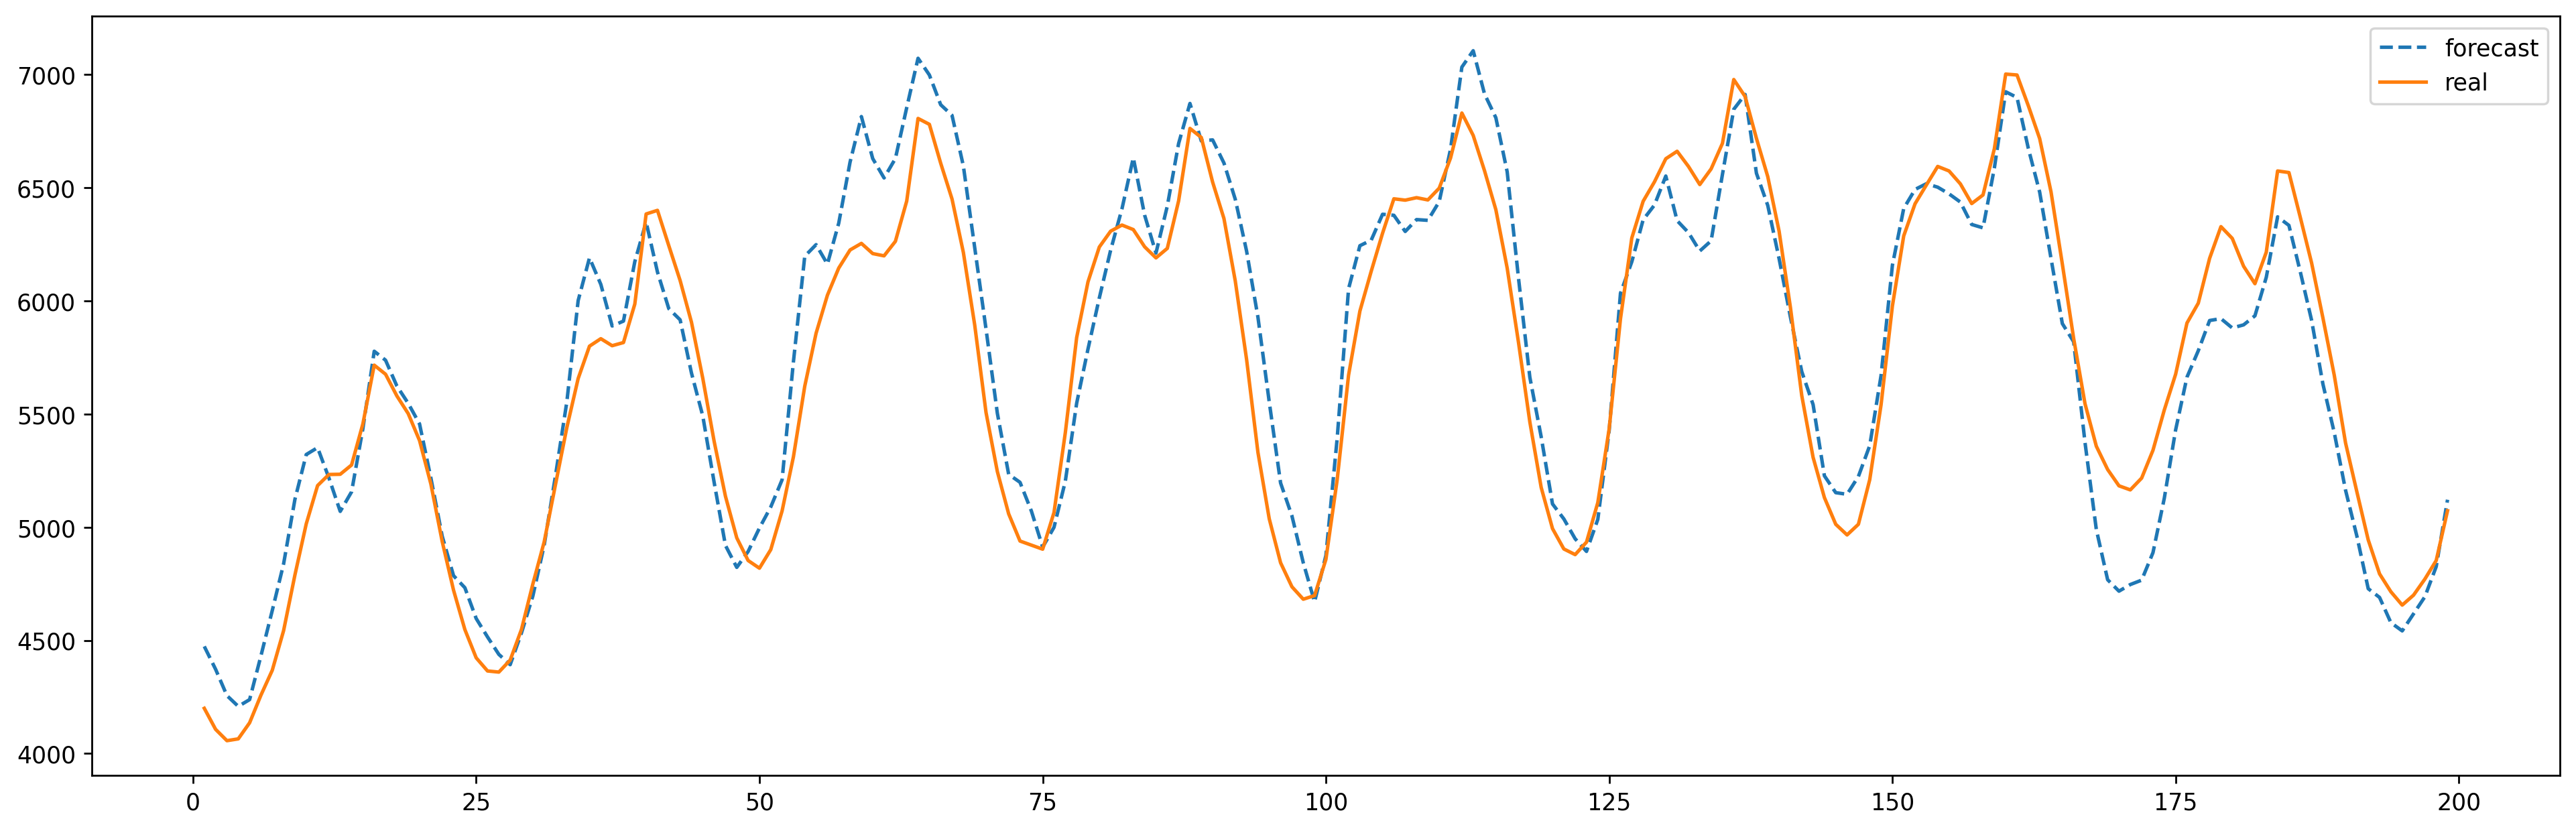

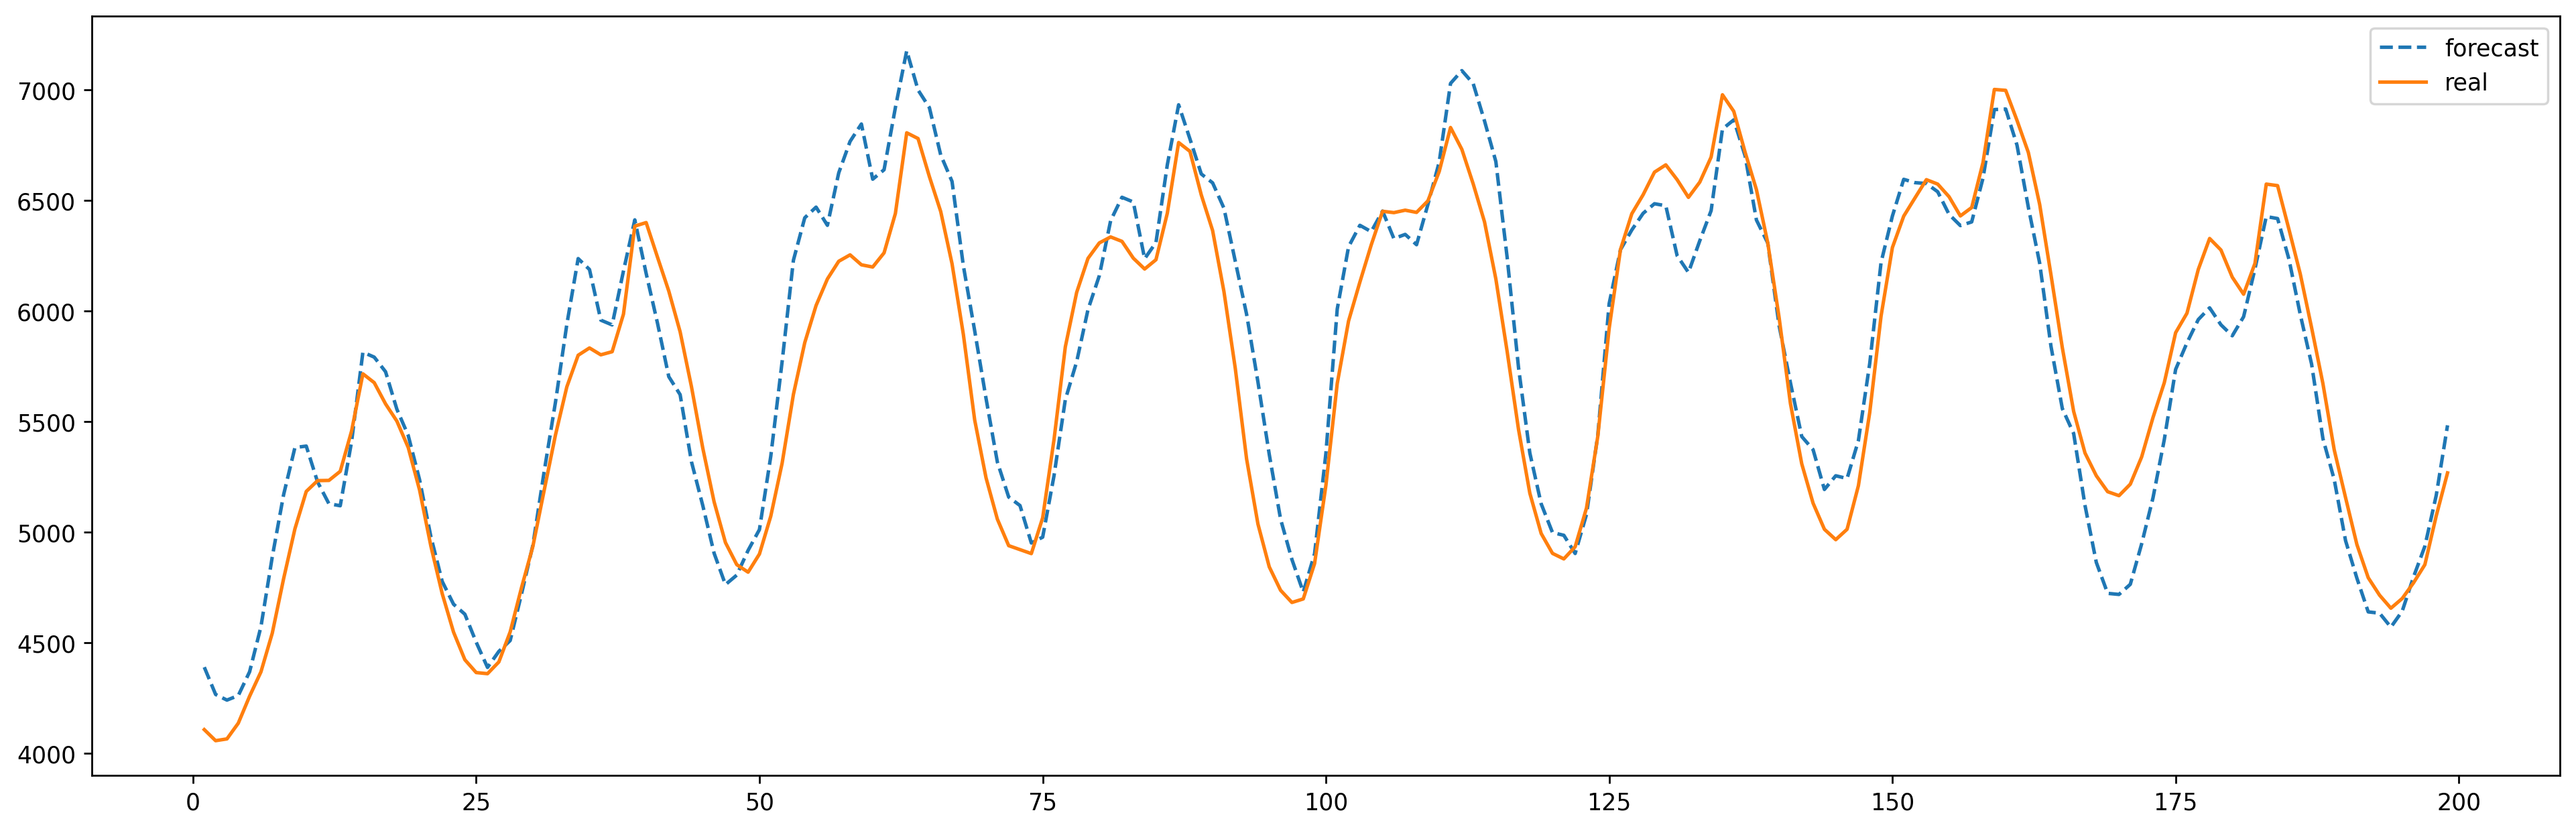

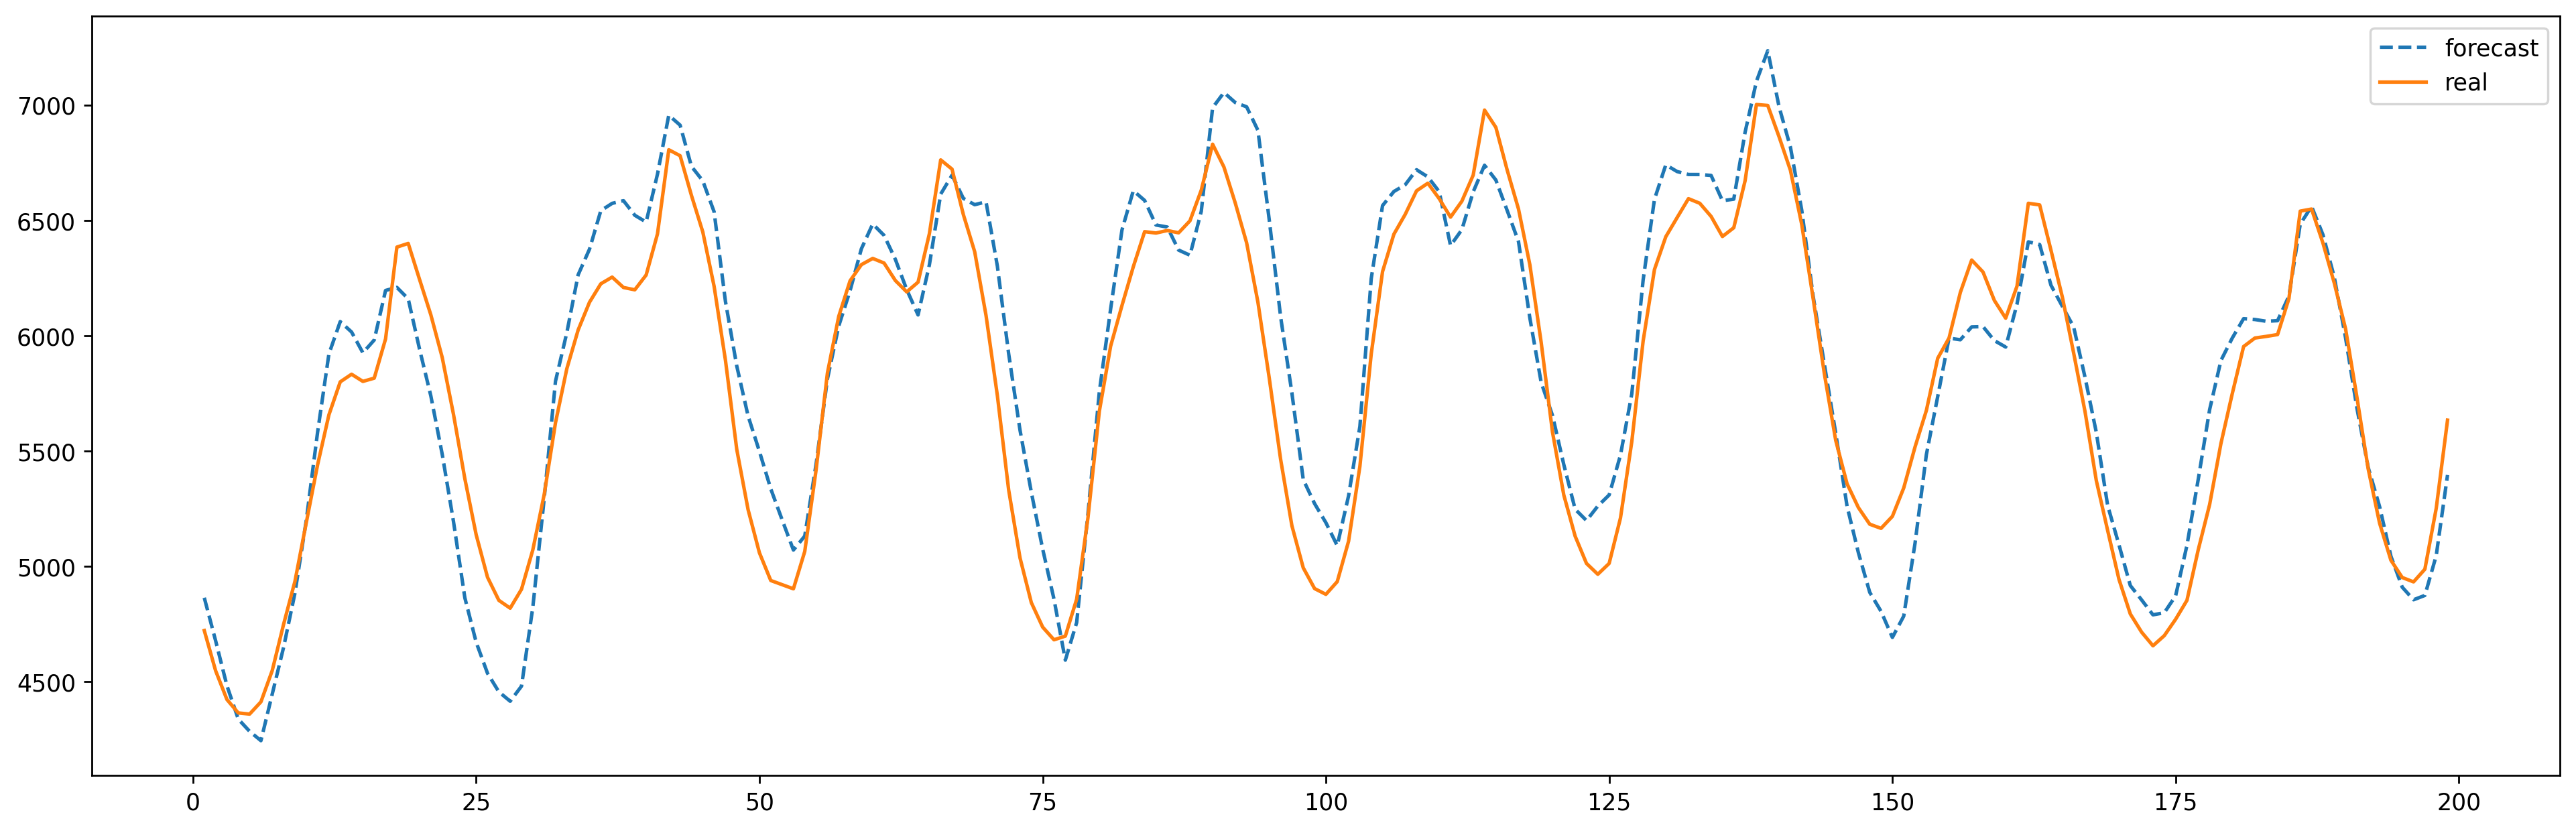

In [ ]:
# create an empty dataframe  
df = pd.DataFrame()
df['forcasted_demand_1h'] = 0
df['forcasted_demand_2h'] = 0
df['forcasted_demand_3h'] = 0
df['forcasted_demand_24h'] = 0
df['real_demand_1h'] = 0
df['real_demand_2h'] = 0
df['real_demand_3h'] = 0
df['real_demand_24h'] = 0

for i in range(len(preds)):
    prediction_descaled=[]
    values_descaled=[]
    prediction_descaled = descale(descaler, preds[[i]].reshape(-1))
    values_descaled = descale(descaler, true[[i]].reshape(-1))
    new_row = {'forcasted_demand_1h':prediction_descaled[0], 
           'forcasted_demand_2h':prediction_descaled[1], 
           'forcasted_demand_3h':prediction_descaled[2],
           'forcasted_demand_24h':prediction_descaled[23],
           'real_demand_1h' : values_descaled[0],
           'real_demand_2h' : values_descaled[1],
           'real_demand_3h' : values_descaled[2],
           'real_demand_24h' : values_descaled[23]}
    
    df = df.append(new_row, ignore_index=True)

print('error for next 1 hour prediction')
error_1h = calculate_metrics(df.forcasted_demand_1h,df.real_demand_1h )
print("\n")
print('error for next 2 hour prediction')
error_2h = calculate_metrics(df.forcasted_demand_2h,df.real_demand_2h )
print("\n")
print('error for next 3 hour prediction')
error_3h = calculate_metrics(df.forcasted_demand_3h,df.real_demand_3h )
print("\n")
print('error for next 24 hour prediction')
error_24h = calculate_metrics(df.forcasted_demand_24h,df.real_demand_24h )
print("\n")



print('1-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[0:200], df.forcasted_demand_1h[0:200], "--", label="forecast")
plt.plot(dates[0:200], df.real_demand_1h[0:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('2-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_1h))
plt.plot(dates[1:200], df.forcasted_demand_2h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_2h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

print('3-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_3h))
plt.plot(dates[1:200], df.forcasted_demand_3h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_3h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();


print('24-step ahead forecast')
figure(figsize=(19, 6), dpi=250)
dates = range(len(df.real_demand_24h))
plt.plot(dates[1:200], df.forcasted_demand_24h[1:200], "--", label="forecast")
plt.plot(dates[1:200], df.real_demand_24h[1:200], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();

Visualizing the seires (the next 24-hour forecast)

In [ ]:
prediction_descaled=[]
values_descaled=[]
for i in range(len(preds)):
    prediction_descaled.append(descale(descaler, preds[[i]].reshape(-1)))
    values_descaled.append(descale(descaler, true[[i]].reshape(-1)))

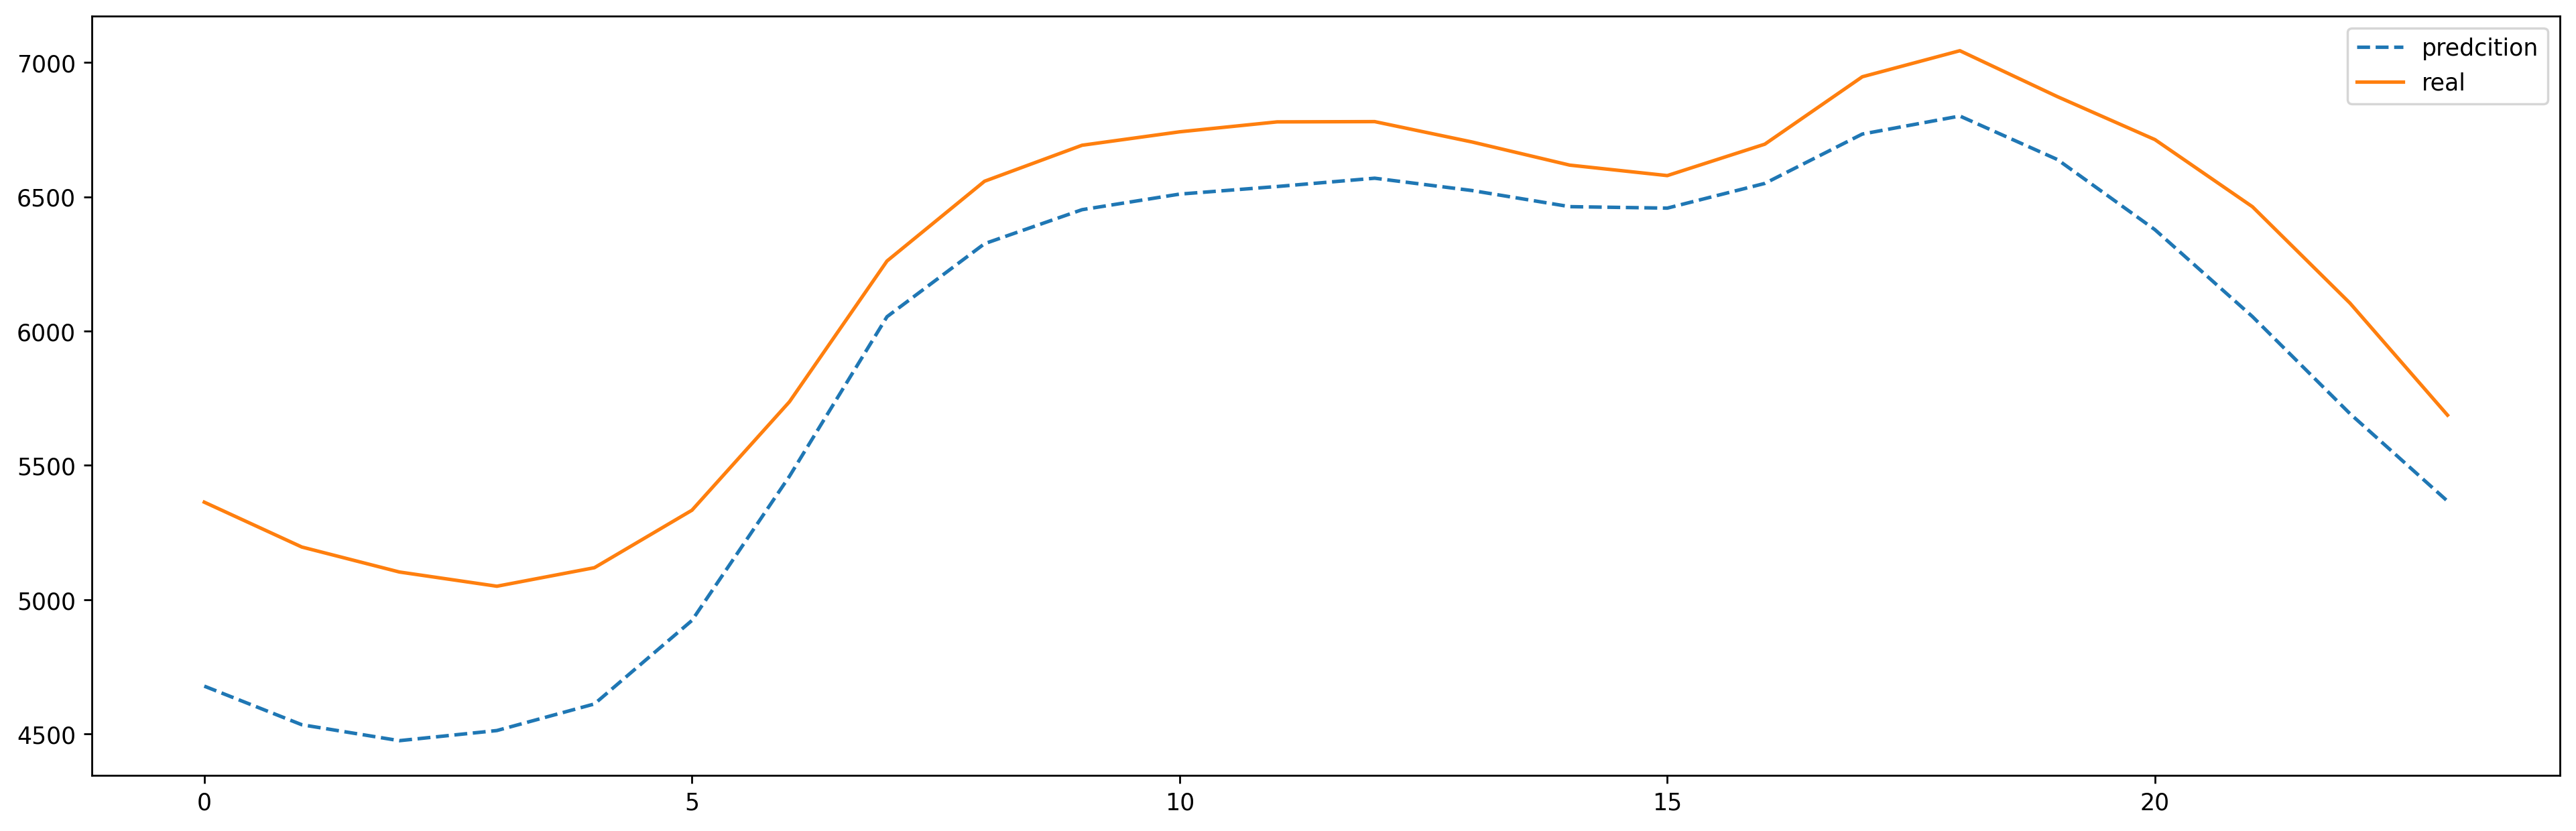

In [ ]:
figure(figsize=(19, 6), dpi=250)

j=30*24
dates = range(len(prediction_descaled[j]))
plt.plot(dates[0:24], prediction_descaled[j] , "--", label="predcition")
plt.plot(dates[0:24], values_descaled[j], "-", label="real")
plt.xticks(rotation = 0)
plt.legend();
